https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-whale-tails.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from pathlib import Path
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
DATA_DIR = Path("./data/tiles/ls7")

MAX_X = 255
MAX_Y = 65535  # TODO: Tilegen outputs rgb image, not grayscale

BAND_DIRS = sorted(list(DATA_DIR.glob("B*")))
TRUTH_DIR = DATA_DIR / "truth"

display(BAND_DIRS)
display(list())

[PosixPath('data/tiles/ls7/B1'),
 PosixPath('data/tiles/ls7/B2'),
 PosixPath('data/tiles/ls7/B3'),
 PosixPath('data/tiles/ls7/B4'),
 PosixPath('data/tiles/ls7/B5'),
 PosixPath('data/tiles/ls7/B7')]

[]

In [3]:
truth_paths = list(TRUTH_DIR.glob("*.png"))

In [4]:
def read_fname(fname):
    truth = np.array(Image.open(TRUTH_DIR / fname)) / MAX_Y
    bands = np.asarray([np.array(Image.open(band_dir / fname)) for band_dir in BAND_DIRS]) / MAX_X
#     bands = bands[1:4][::-1]
    mchannel = np.dstack(bands)
    return mchannel, truth

def rgb_transform(ds):
#     return np.flip(ds, 3)  # Bands 2, 3, 4 -> rgb
    return np.flip(ds[:,:,:,1:4], 3)  # Bands 1, 2, 3, 4, 5, 7 -> rgb

In [5]:
display(truth_paths[0].name)

x0, y0 = read_fname(truth_paths[0].name)

display(x0.shape)
display(y0.shape)


'LC08_L1TP_044006_20150711_20170227_01_T1_TILE5376_1536_512_512__T0.png'

(512, 512, 6)

(512, 512)

In [6]:
img_lst = []
msk_lst = []

for truth_path in truth_paths:
    img, truth = read_fname(truth_path.name)
    img_lst.append(img)
    msk_lst.append(truth)

img_np = np.asarray(img_lst)
msk_np = np.asarray(msk_lst)
msk_np = msk_np.reshape(msk_np.shape[0], msk_np.shape[1], msk_np.shape[2], 1)

del img_lst
del msk_lst

display(f'{img_np.shape=}')
display(f'{msk_np.shape=}')

'img_np.shape=(498, 512, 512, 6)'

'msk_np.shape=(498, 512, 512, 1)'

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


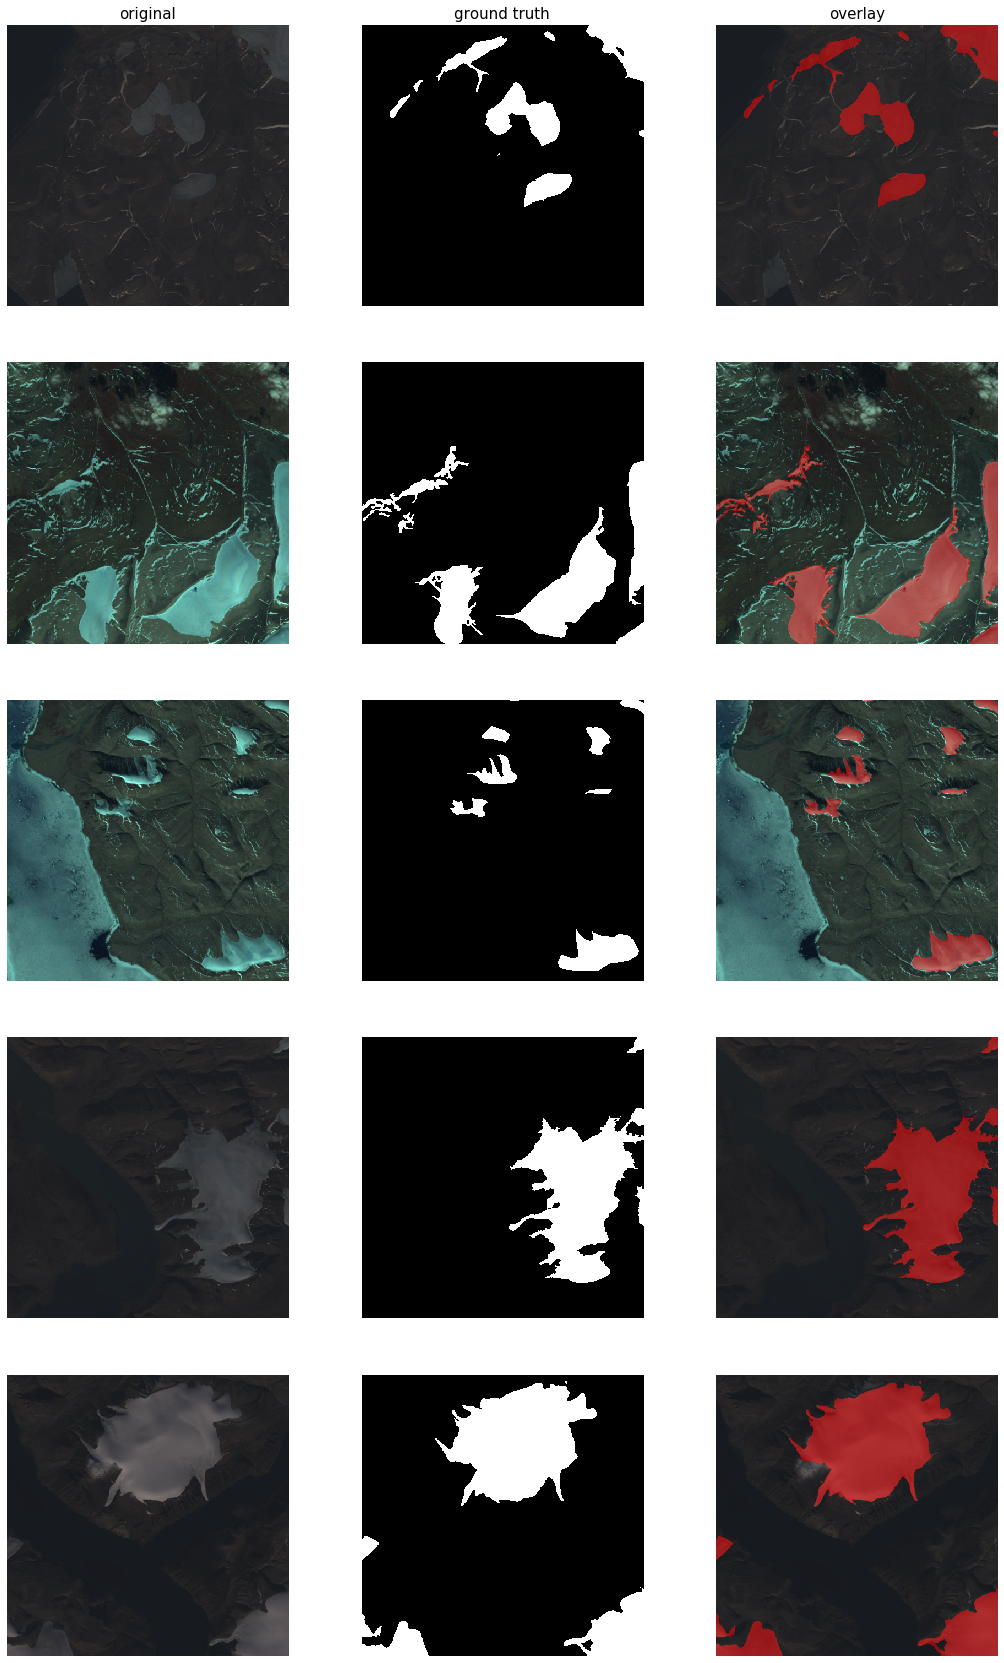

In [7]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=rgb_transform(img_np), mask_imgs=msk_np, nm_img_to_plot=5, figsize=6)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(img_np, msk_np, test_size=0.30, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (348, 512, 512, 6)
y_train:  (348, 512, 512, 1)
x_val:  (150, 512, 512, 6)
y_val:  (150, 512, 512, 1)


In [9]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=360.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# train_gen = get_augmented(
#     x_train, y_train, batch_size=2,
#     data_gen_args=dict(
#         rotation_range=0.,
#         width_shift_range=0.00,
#         height_shift_range=0.00,
#         shear_range=0,
#         zoom_range=0.0,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='constant'
#     )
# )

/usr/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:931: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (348, 512, 512, 6) (6 channels).
  warnings.warn(
/usr/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:120: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (348, 512, 512, 6) (6 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


(2, 512, 512, 6) (2, 512, 512, 1)


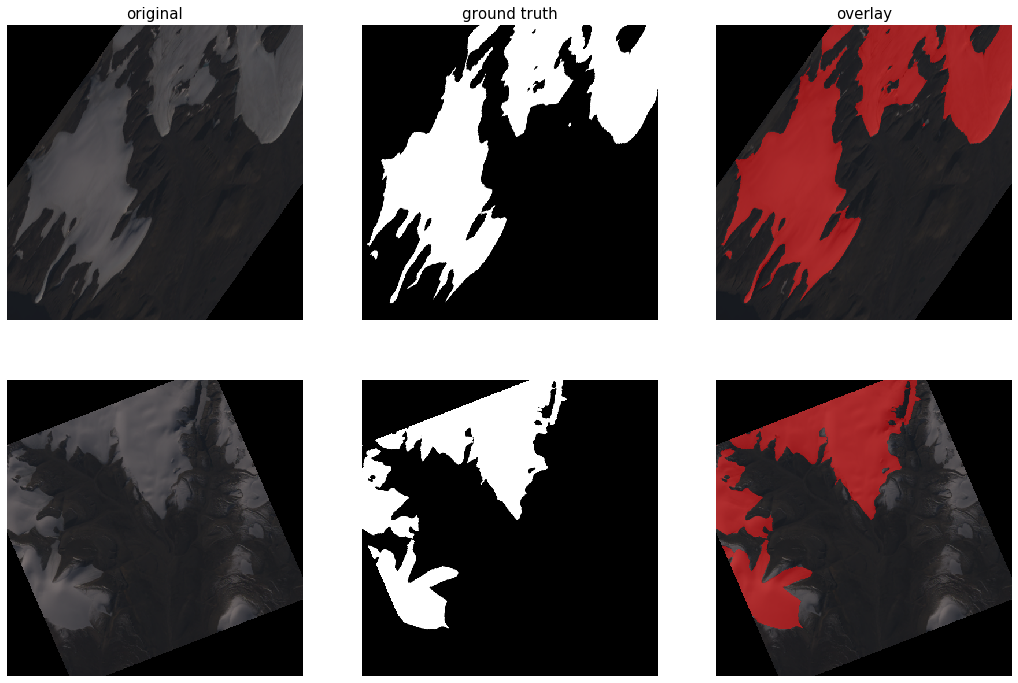

In [10]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=rgb_transform(xx), mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [11]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape
display(input_shape)

model = custom_unet(
    input_shape,
    filters=40,
    use_batch_norm=True,
    dropout=0.15,  # 0.3
    dropout_change_per_layer=0.0,
    num_layers=5
)


(512, 512, 6)

In [12]:
display(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 40) 2160        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 40) 160         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 40) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

None

In [13]:
model_filename = 'model_trainchpt.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)


In [14]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
#     loss='binary_crossentropy',
    loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=400,
    epochs=500,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)


Epoch 1/500
298/400 [=====================>........] - ETA: 18s - loss: 0.0889 - iou: 0.7377 - iou_thresholded: 0.7661

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
model.load_weights(model_filename)

In [ ]:
y_pred = model.predict(x_val)

In [ ]:
from keras_unet.utils import plot_imgs

display(len(x_val))
plot_imgs(org_imgs=rgb_transform(x_val), mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10, figsize=4)